# Connect model with my own Drive Account

In [1]:
from google.colab import auth
from google.auth import default
import gspread
from gspread_dataframe import get_as_dataframe

# Authentication
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Set up an overview of the data

## Import necessary library

In [3]:
!pip install xgboost
!pip install imbalanced-learn
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.2 MB/s eta 0:00:00


In [4]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import category_encoders as ce
from imblearn.over_sampling import SMOTE, SVMSMOTE

## Import Data

In [5]:
file_path1 = '/content/drive/My Drive/ABCXYZ/80.csv'
customer_data = pd.read_csv(file_path1)

file_path2 = '/content/drive/My Drive/ABCXYZ/20.csv'
customer_data2 = pd.read_csv(file_path2)

In [6]:
customer_data

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,SC,79,415,No,No,0,134.7,98,22.90,189.7,68,16.12,221.4,128,9.96,11.8,5,3.19,2,False
2662,AZ,192,415,No,Yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
2663,WV,68,415,No,No,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
2664,RI,28,510,No,No,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False


# EDA

In [7]:
customer_data.info() # xem information của data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

In [8]:
customer_data.isnull().sum() # xem có null hay không, nếu có thì phải xử lí null

,0
State,0
Account length,0
Area code,0
International plan,0
Voice mail plan,0
Number vmail messages,0
Total day minutes,0
Total day calls,0
Total day charge,0
Total eve minutes,0


In [9]:
import pandas as pd
cols_to_convert = ['State', 'Area code', 'International plan', 'Voice mail plan', 'Churn']
customer_data[cols_to_convert] = customer_data[cols_to_convert].astype('object')
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   object 
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

In [10]:
object_cols = [f for f in customer_data.columns if customer_data[f].dtype == 'object']
object_cols

['State', 'Area code', 'International plan', 'Voice mail plan', 'Churn']

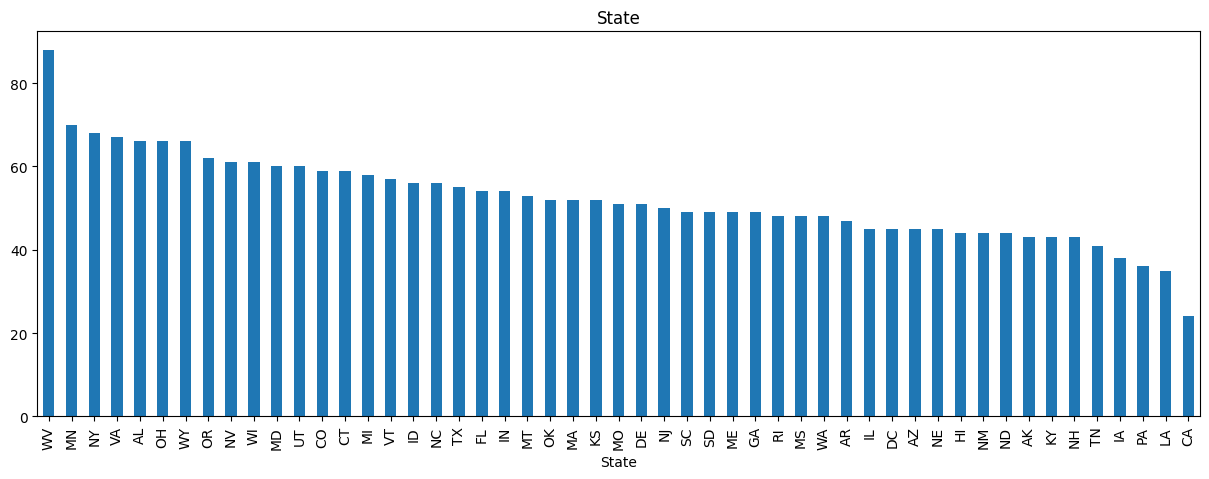

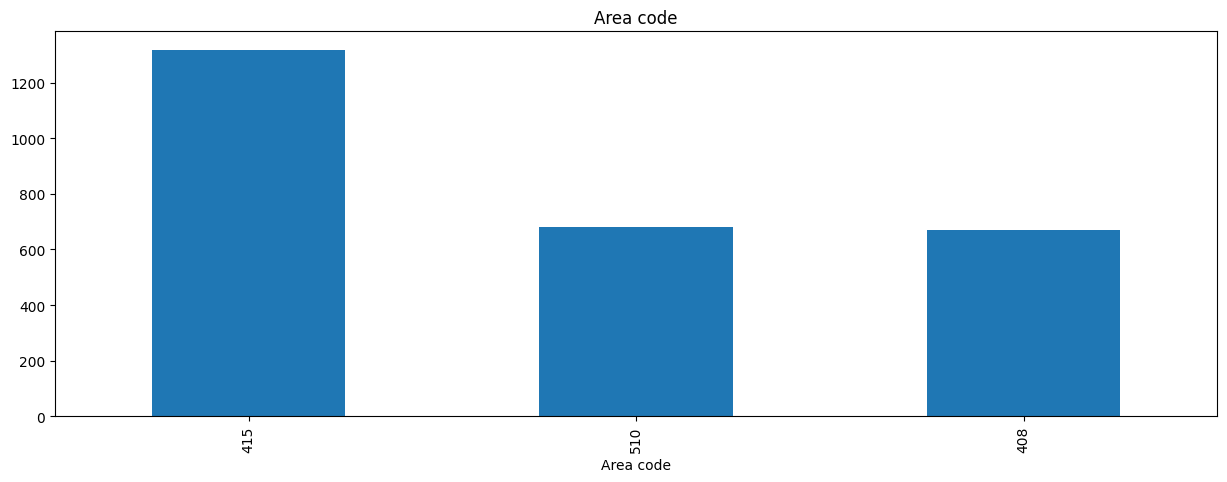

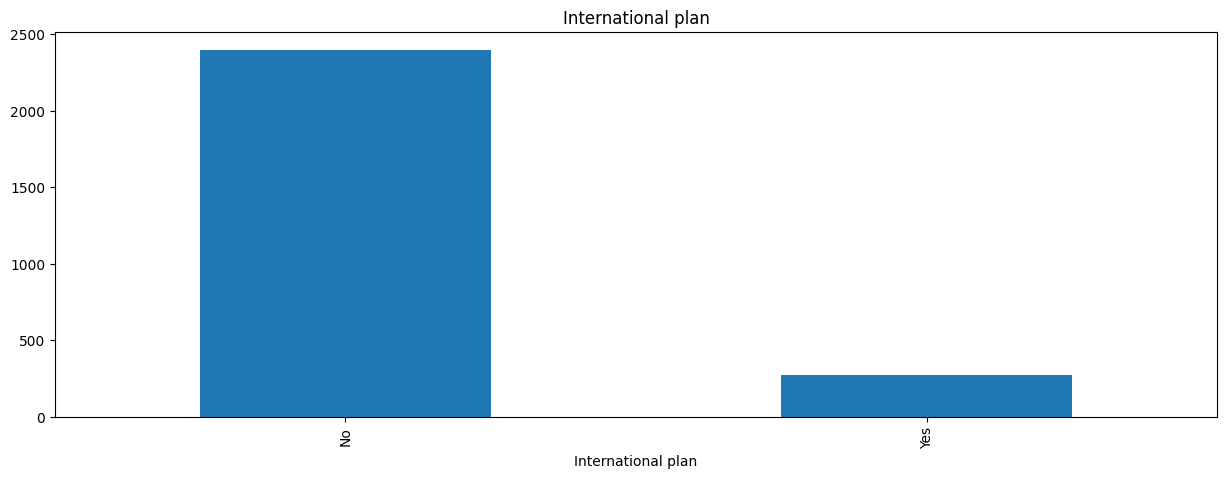

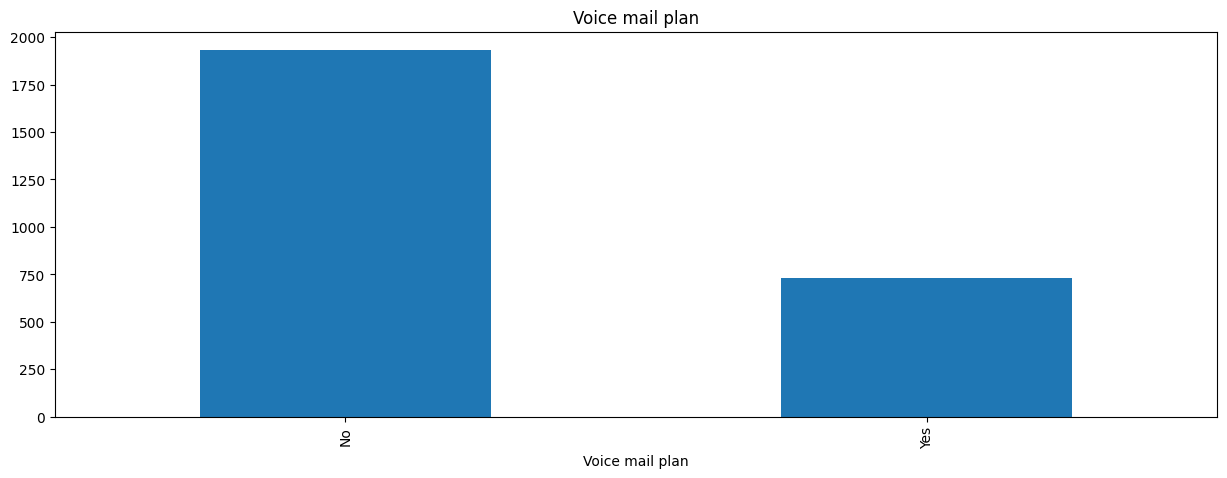

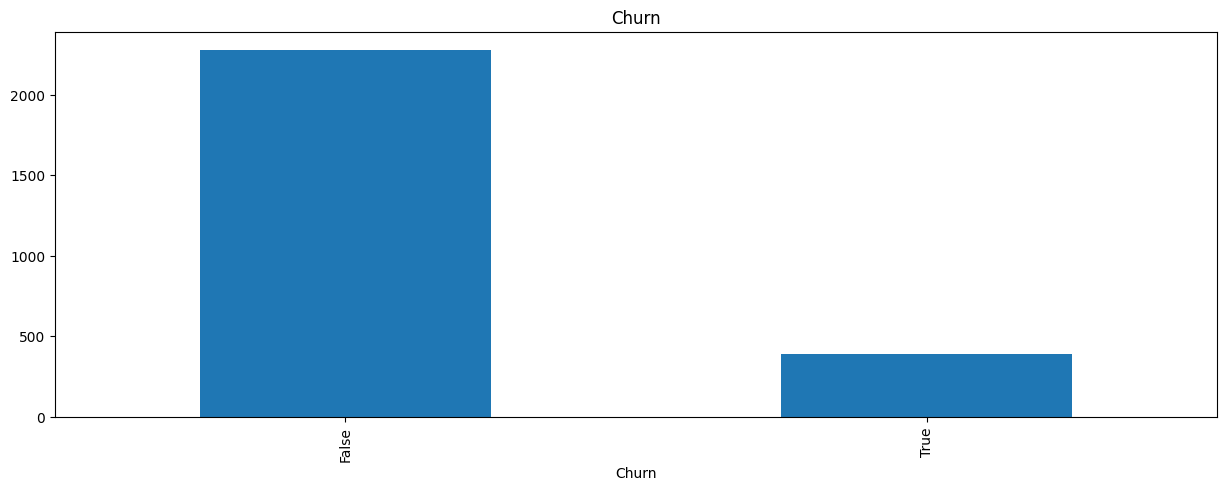

In [11]:
for col in object_cols:
    customer_data[col].value_counts().plot(kind='bar', figsize=(15, 5))
    plt.title(col)
    plt.show()

In [12]:
numeric_cols = [f for f in customer_data.columns if customer_data[f].dtype != 'object']
print(numeric_cols)

['Account length', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls']


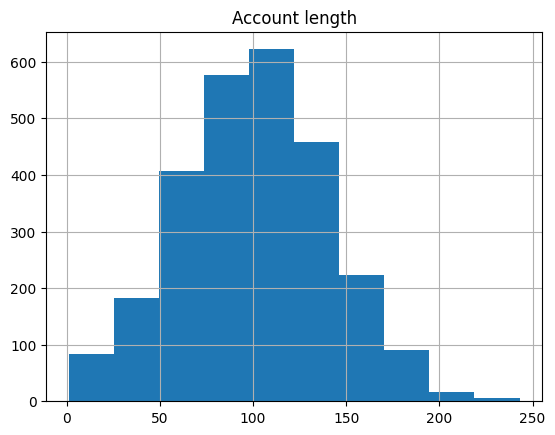

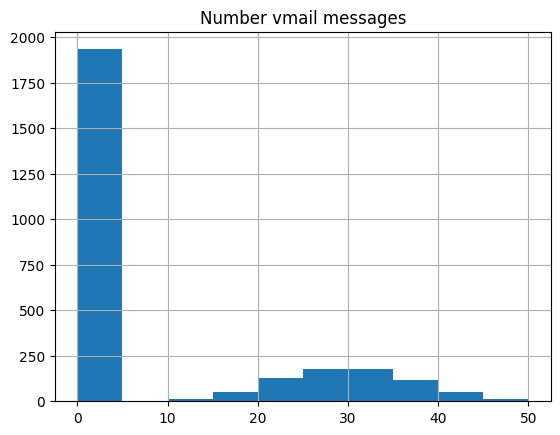

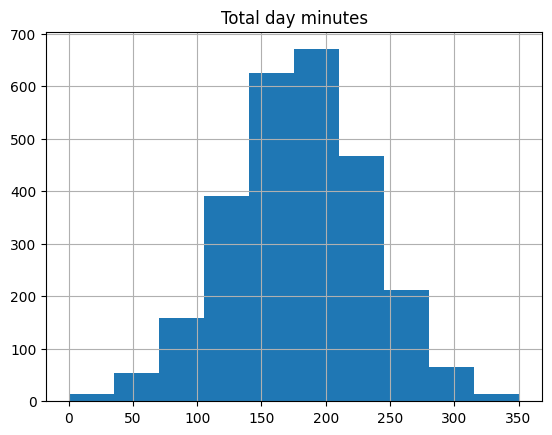

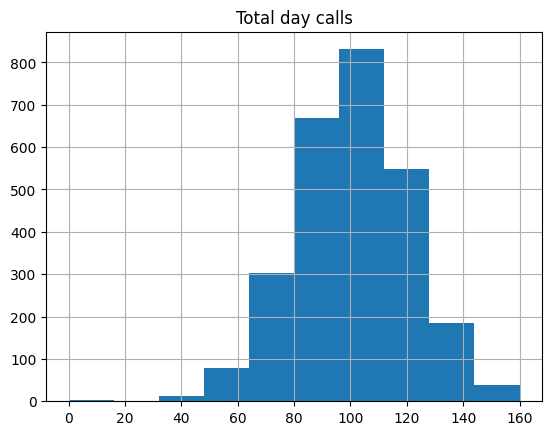

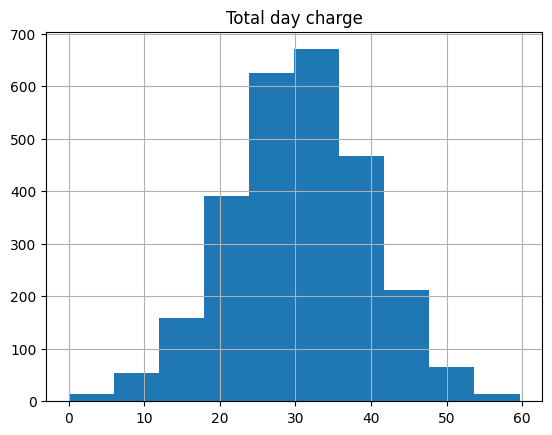

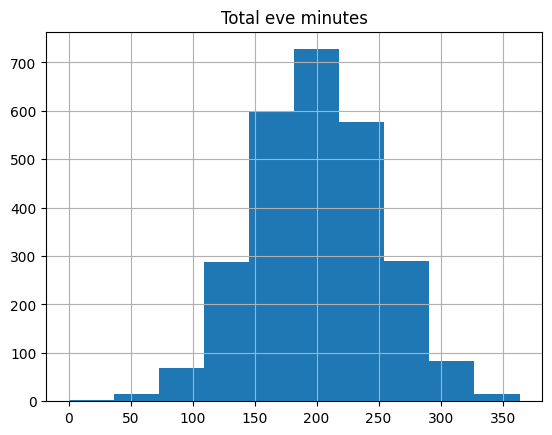

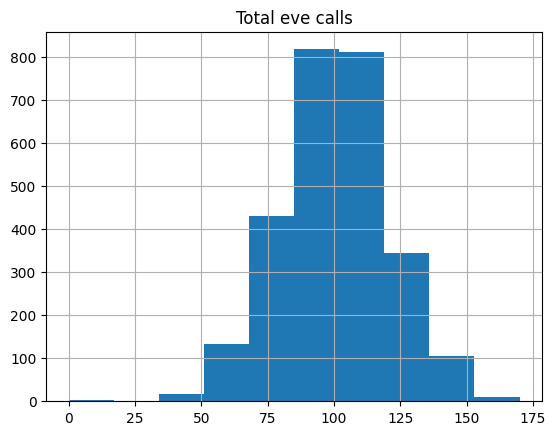

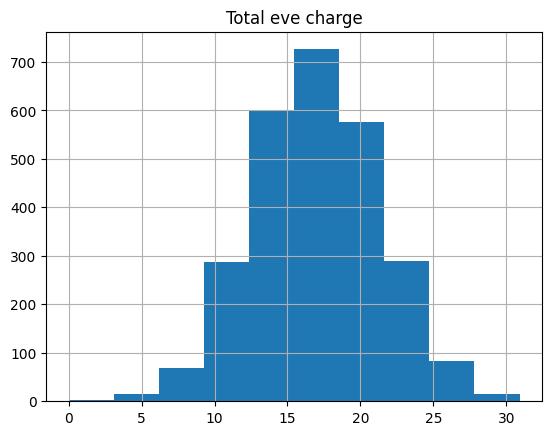

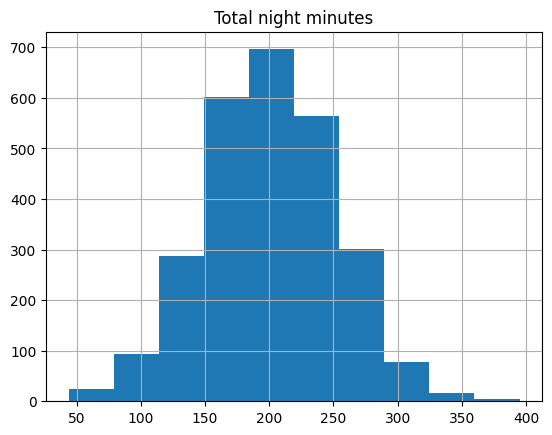

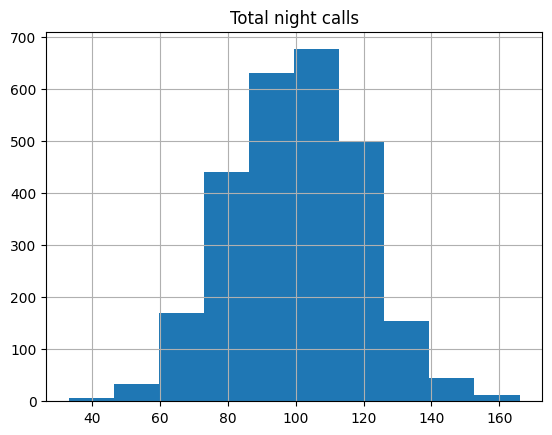

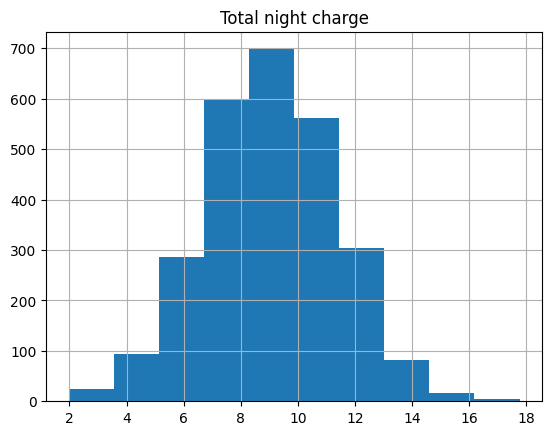

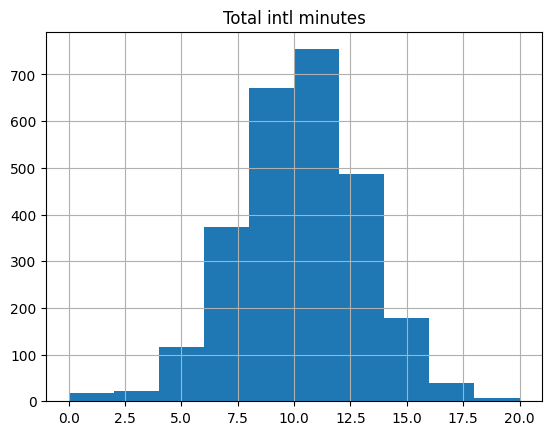

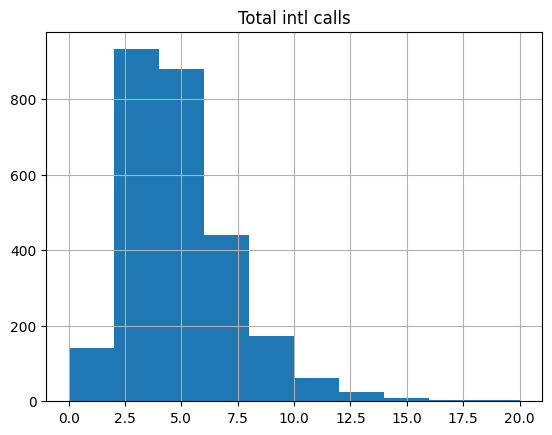

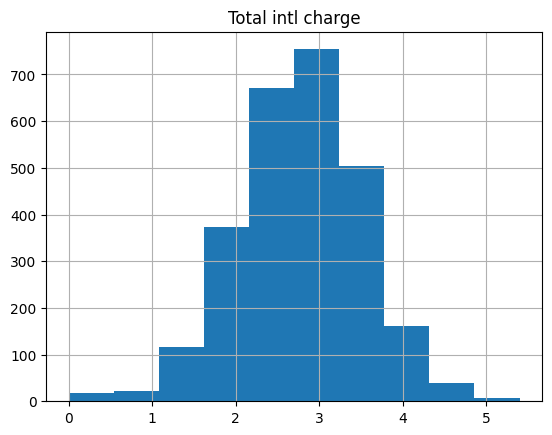

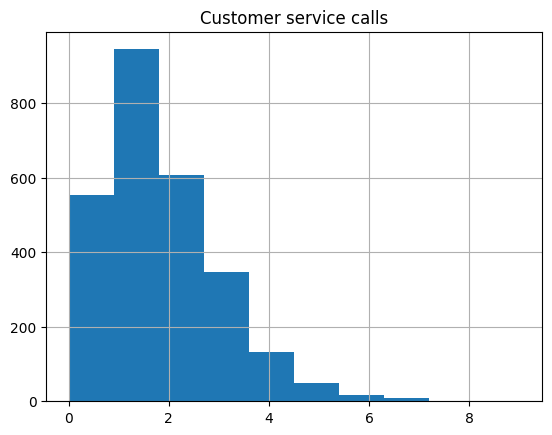

In [13]:
for col in numeric_cols:
    customer_data[col].hist()
    plt.title(col)
    plt.show()

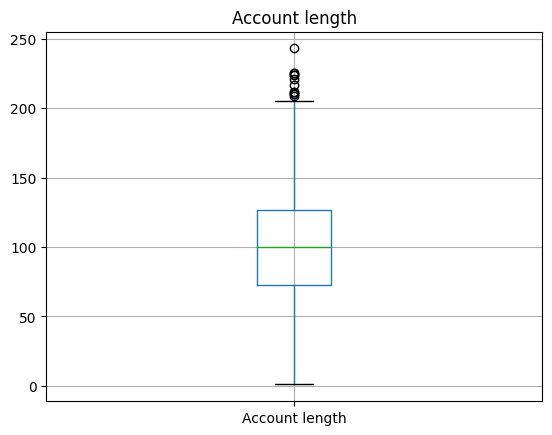

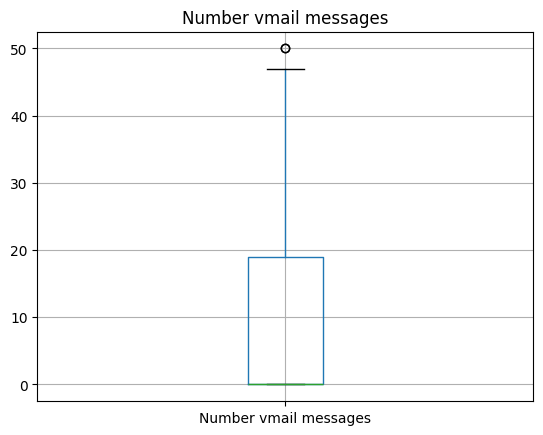

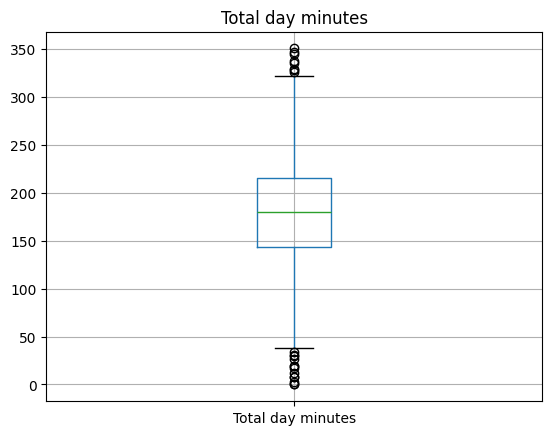

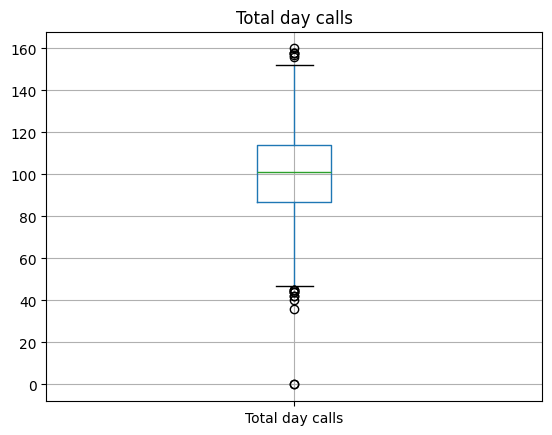

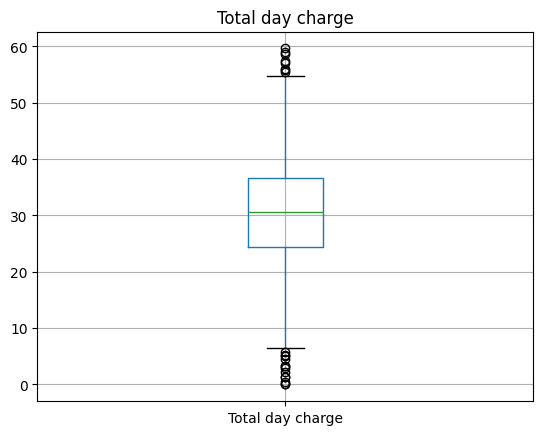

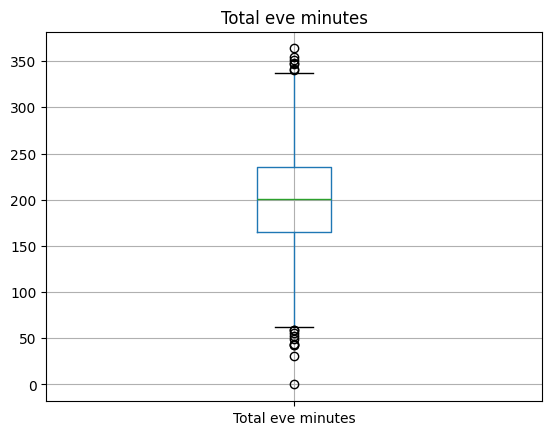

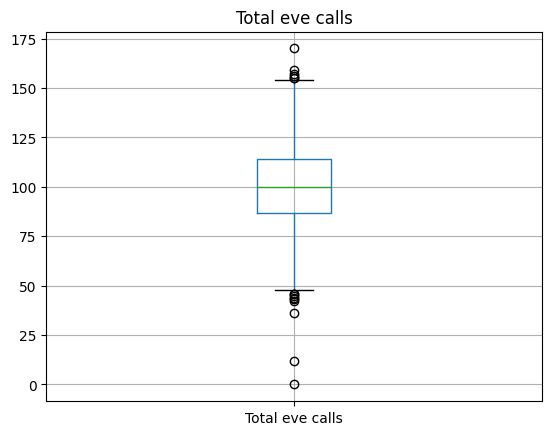

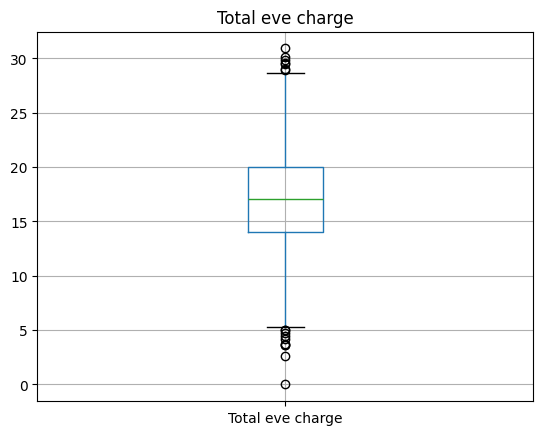

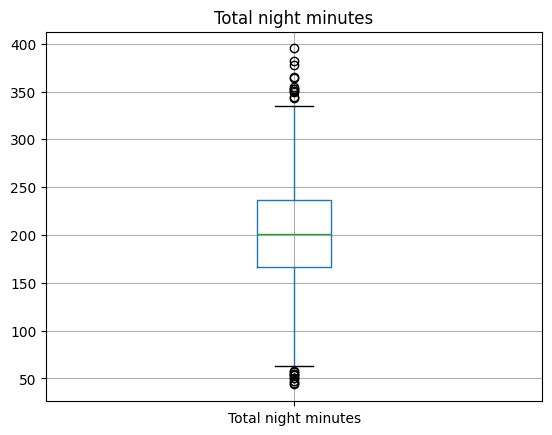

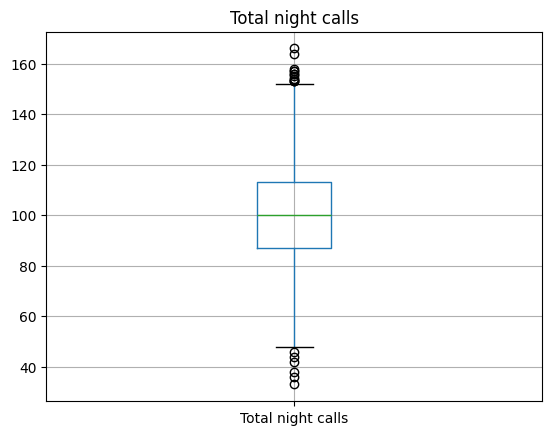

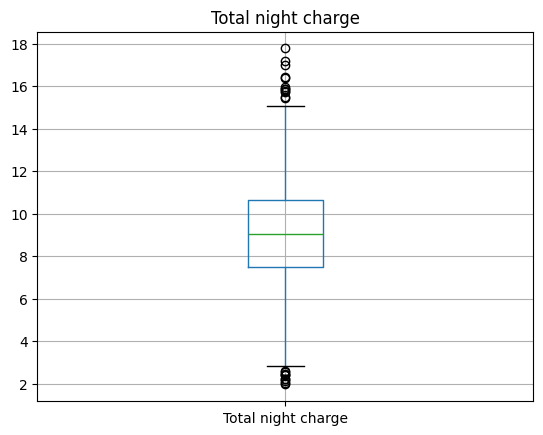

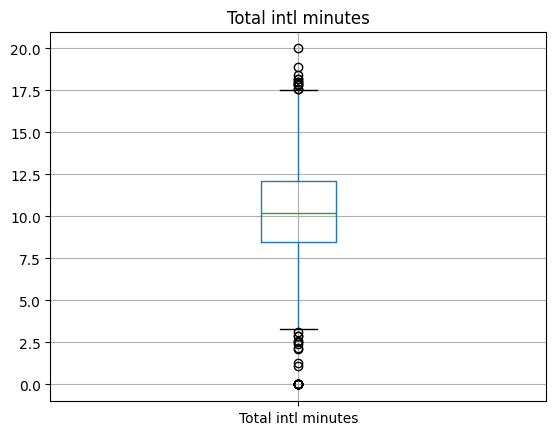

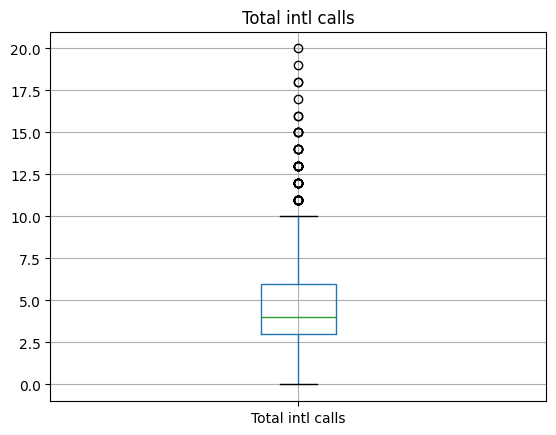

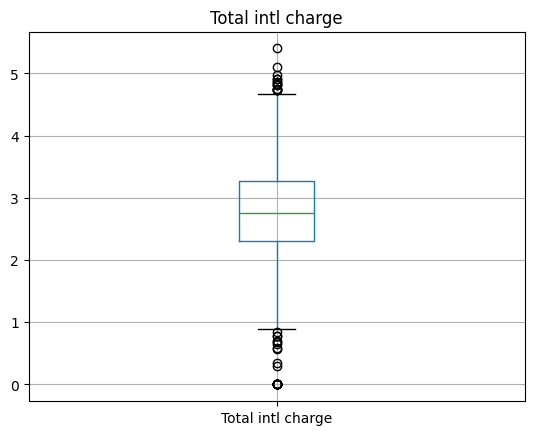

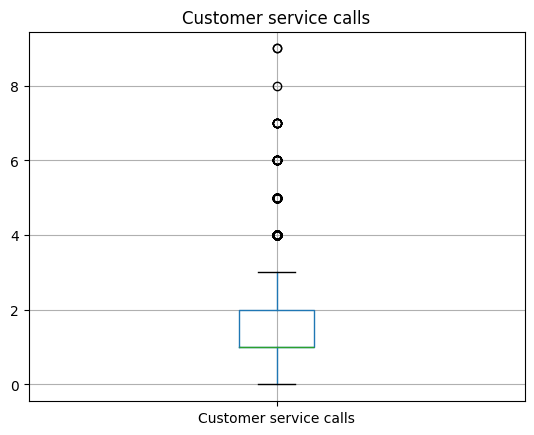

In [14]:
for col in numeric_cols:
    customer_data.boxplot(column=[col])
    plt.title(col)
    plt.show()

# Preprocessing Data

In [15]:
dataset = customer_data.copy()

In [16]:
dataset

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,SC,79,415,No,No,0,134.7,98,22.90,189.7,68,16.12,221.4,128,9.96,11.8,5,3.19,2,False
2662,AZ,192,415,No,Yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
2663,WV,68,415,No,No,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
2664,RI,28,510,No,No,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False


In [17]:
he = ce.HashingEncoder(cols='State')
dataset_hash = he.fit_transform(dataset)
dataset_hash
#remove state column and using hash number

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Account length,Area code,...,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,0,1,0,0,0,0,0,0,128,415,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,0,0,0,0,1,0,0,0,107,415,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,0,1,0,0,0,0,0,0,137,415,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,0,0,0,0,1,0,0,0,84,408,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,0,0,0,0,1,0,0,0,75,415,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,0,0,0,0,0,1,0,0,79,415,...,68,16.12,221.4,128,9.96,11.8,5,3.19,2,False
2662,0,0,0,0,0,0,1,0,192,415,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
2663,0,0,0,0,0,0,1,0,68,415,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
2664,0,0,1,0,0,0,0,0,28,510,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False


In [18]:
dataset_hash_dummy = pd.get_dummies(dataset_hash, drop_first=True)
dataset_hash_dummy

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Account length,Number vmail messages,...,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Area code_415,Area code_510,International plan_Yes,Voice mail plan_Yes,Churn_True
0,0,1,0,0,0,0,0,0,128,25,...,11.01,10.0,3,2.70,1,True,False,False,True,False
1,0,0,0,0,1,0,0,0,107,26,...,11.45,13.7,3,3.70,1,True,False,False,True,False
2,0,1,0,0,0,0,0,0,137,0,...,7.32,12.2,5,3.29,0,True,False,False,False,False
3,0,0,0,0,1,0,0,0,84,0,...,8.86,6.6,7,1.78,2,False,False,True,False,False
4,0,0,0,0,1,0,0,0,75,0,...,8.41,10.1,3,2.73,3,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,0,0,0,0,0,1,0,0,79,0,...,9.96,11.8,5,3.19,2,True,False,False,False,False
2662,0,0,0,0,0,0,1,0,192,36,...,12.56,9.9,6,2.67,2,True,False,False,True,False
2663,0,0,0,0,0,0,1,0,68,0,...,8.61,9.6,4,2.59,3,True,False,False,False,False
2664,0,0,1,0,0,0,0,0,28,0,...,8.64,14.1,6,3.81,2,False,True,False,False,False


In [19]:
#view correlation
corr = dataset_hash_dummy.corr()
styled_corr = corr.style.background_gradient(cmap='coolwarm').format(precision=2)
styled_corr

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Account length,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Area code_415,Area code_510,International plan_Yes,Voice mail plan_Yes,Churn_True
col_0,1.00,-0.20,-0.12,-0.16,-0.20,-0.11,-0.20,-0.14,0.02,0.03,0.01,0.00,0.01,0.01,0.01,0.01,0.01,-0.04,0.01,-0.02,-0.01,-0.02,0.01,-0.01,-0.02,0.00,0.03,-0.04
col_1,-0.20,1.00,-0.12,-0.16,-0.20,-0.11,-0.19,-0.14,0.00,0.00,0.06,0.00,0.06,-0.02,0.01,-0.02,-0.02,0.01,-0.02,0.03,0.01,0.03,0.02,0.02,-0.03,-0.00,-0.00,0.05
col_2,-0.12,-0.12,1.00,-0.10,-0.12,-0.07,-0.12,-0.09,-0.01,-0.02,-0.03,-0.01,-0.03,0.03,-0.04,0.03,-0.00,0.04,-0.00,-0.01,0.01,-0.01,-0.02,-0.02,0.01,-0.02,-0.01,-0.00
col_3,-0.16,-0.16,-0.10,1.00,-0.16,-0.09,-0.16,-0.12,0.02,-0.01,-0.00,0.02,-0.00,0.03,0.02,0.03,0.01,0.00,0.01,0.00,-0.02,0.00,0.02,-0.00,0.03,0.03,-0.01,-0.00
col_4,-0.20,-0.20,-0.12,-0.16,1.00,-0.11,-0.19,-0.14,0.00,0.00,0.02,-0.00,0.02,0.02,0.02,0.02,0.04,0.01,0.04,0.01,-0.02,0.01,-0.02,-0.01,0.00,0.02,0.01,0.02
col_5,-0.11,-0.11,-0.07,-0.09,-0.11,1.00,-0.11,-0.08,-0.03,-0.00,-0.04,0.01,-0.04,0.01,-0.01,0.01,-0.01,0.01,-0.01,-0.02,-0.02,-0.02,-0.01,0.02,-0.01,-0.01,-0.00,0.05
col_6,-0.20,-0.19,-0.12,-0.16,-0.19,-0.11,1.00,-0.14,-0.01,-0.00,-0.03,-0.01,-0.03,-0.08,-0.03,-0.08,-0.02,0.01,-0.02,0.01,0.03,0.01,0.01,0.03,-0.01,-0.04,-0.01,-0.05
col_7,-0.14,-0.14,-0.09,-0.12,-0.14,-0.08,-0.14,1.00,-0.01,-0.01,-0.01,-0.01,-0.01,0.01,0.02,0.01,-0.03,-0.01,-0.03,-0.02,-0.00,-0.02,-0.02,-0.02,0.04,0.02,-0.01,-0.01
Account length,0.02,0.00,-0.01,0.02,0.00,-0.03,-0.01,-0.01,1.00,-0.00,0.00,0.04,0.00,-0.02,0.02,-0.02,-0.01,-0.02,-0.01,0.01,0.02,0.01,0.00,0.00,-0.01,0.02,0.00,0.02
Number vmail messages,0.03,0.00,-0.02,-0.01,0.00,-0.00,-0.00,-0.01,-0.00,1.00,0.02,-0.01,0.02,0.01,0.01,0.01,-0.00,0.01,-0.00,-0.00,0.03,-0.00,-0.02,0.01,-0.00,0.01,0.96,-0.09


In [20]:
# remove correlation column
dataset_hash_dummy_drop_corr = dataset_hash_dummy.drop(columns=['Voice mail plan_Yes', 'Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge'])


# Scenario 1: Upsampling = SMOTE, Scale = MINMAX and test with logistic

In [21]:
# SMOTE & Scale
x = dataset_hash_dummy_drop_corr.drop(columns=['Churn_True'])
y = dataset_hash_dummy_drop_corr['Churn_True']

# Division train, test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Upsampling = SMOTE
sm = SMOTE(k_neighbors=5)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

#Scale
scale_column = ['Account length', 'Number vmail messages', 'Total day minutes',
                'Total day calls', 'Total eve minutes', 'Total eve calls',
                'Total night minutes', 'Total night calls', 'Total intl minutes', 'Total intl calls',
                'Customer service calls']


scaler = MinMaxScaler()
scaler.fit(X_train_resampled[scale_column])
X_train_resampled[scale_column] = scaler.fit_transform(X_train_resampled[scale_column])
X_test[scale_column] = scaler.transform(X_test[scale_column])

In [22]:
X_train_resampled

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Account length,Number vmail messages,...,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,Area code_415,Area code_510,International plan_Yes
0,0,0,0,0,0,0,1,0,0.528926,0.00,...,0.556778,0.529412,0.539140,0.461538,0.631868,0.30,0.222222,True,False,False
1,0,0,0,0,0,1,0,0,0.318182,0.00,...,0.590597,0.341176,0.448619,0.853846,0.593407,0.30,0.111111,True,False,False
2,0,0,0,0,0,0,1,0,0.140496,0.00,...,0.434974,0.482353,0.489610,0.630769,0.565934,0.10,0.555556,False,False,False
3,0,0,1,0,0,0,0,0,0.099174,0.00,...,0.556228,0.641176,0.433248,0.492308,0.692308,0.25,0.222222,True,False,False
4,0,0,1,0,0,0,0,0,0.243802,0.00,...,0.574924,0.541176,0.810703,0.584615,0.802198,0.10,0.111111,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3641,0,0,0,0,0,0,0,0,0.314050,0.00,...,0.458872,0.505882,0.695578,0.507692,0.339673,0.15,0.111111,True,True,False
3642,0,0,0,0,0,0,0,0,0.363636,0.34,...,0.519743,0.641176,0.244237,0.600000,0.461460,0.20,0.111111,True,True,True
3643,0,0,0,0,0,0,0,0,0.632231,0.00,...,0.860767,0.735294,0.396436,0.446154,0.611406,0.25,0.111111,True,False,True
3644,0,0,0,0,0,0,0,0,0.400826,0.00,...,0.590549,0.611765,0.540964,0.300000,0.433909,0.05,0.222222,True,False,False


              precision    recall  f1-score   support

       False       0.88      0.95      0.91       455
        True       0.47      0.27      0.34        79

    accuracy                           0.85       534
   macro avg       0.67      0.61      0.63       534
weighted avg       0.82      0.85      0.83       534



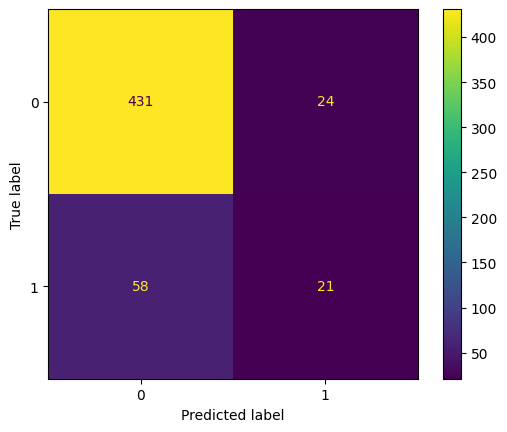

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Logistic Regression
model_log = LogisticRegression()
model_log.fit(X_train_resampled, y_train_resampled)
y_pred = model_log.predict(X_test)

# Print data
print(classification_report(y_test, y_pred))

# Vẽ ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show() #Thêm dòng này để hiển thị biểu đồ

# Scenario 2: XGBOOST, No Upsampling, no scale

In [24]:
# SMOTE & Scale
x = dataset_hash_dummy_drop_corr.drop(columns=['Churn_True'])
y = dataset_hash_dummy_drop_corr['Churn_True']

# Division train, test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


              precision    recall  f1-score   support

       False       0.96      0.99      0.98       455
        True       0.94      0.77      0.85        79

    accuracy                           0.96       534
   macro avg       0.95      0.88      0.91       534
weighted avg       0.96      0.96      0.96       534



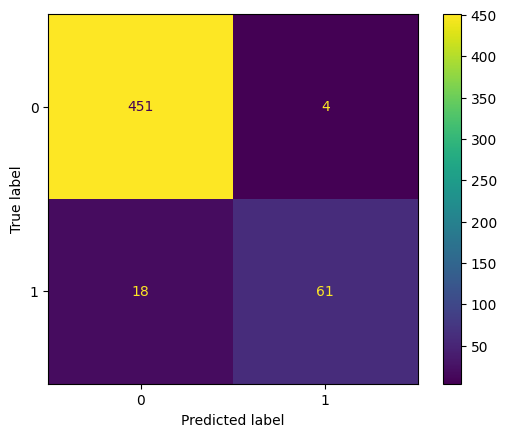

In [25]:
# XGBOOST
import xgboost as xgb

model_xgb = xgb.XGBClassifier(random_state=42, n_estimators = 200)
model_xgb.fit(X_train, y_train)


y_pred = model_xgb.predict(X_test)

#print the report result
print(classification_report(y_test, y_pred))

# Vẽ ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show() #Thêm dòng này để hiển thị biểu đồ

#Submit result

In [26]:
test = pd.read_csv('/content/drive/My Drive/ABCXYZ/20.csv')

In [27]:
test

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,WI,114,415,No,Yes,26,137.1,88,23.31,155.7,125,13.23,247.6,94,11.14,11.5,7,3.11,2,False
663,AL,106,408,No,Yes,29,83.6,131,14.21,203.9,131,17.33,229.5,73,10.33,8.1,3,2.19,1,False
664,VT,60,415,No,No,0,193.9,118,32.96,85.0,110,7.23,210.1,134,9.45,13.2,8,3.56,3,False
665,WV,159,415,No,No,0,169.8,114,28.87,197.7,105,16.80,193.7,82,8.72,11.6,4,3.13,1,False


In [28]:
test_hash_state = he.transform(test)
test_hash_state.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Account length,Area code,...,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,0,1,0,0,0,0,0,0,117,408,...,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,0,0,0,1,0,0,0,0,65,415,...,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,1,0,0,0,0,0,0,0,161,415,...,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,0,0,0,0,0,1,0,0,111,415,...,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,0,0,0,0,0,0,1,0,49,510,...,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


In [29]:
test_dummy = pd.get_dummies(test_hash_state, drop_first=True)
test_dummy_drop_corr = test_dummy.drop(columns=['Area code','Voice mail plan_Yes', 'Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge'])

In [30]:
test_dummy_drop_corr.columns

Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'Account length', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total eve minutes', 'Total eve calls',
       'Total night minutes', 'Total night calls', 'Total intl minutes',
       'Total intl calls', 'Customer service calls', 'Churn',
       'International plan_Yes'],
      dtype='object')

In [31]:
# Ensure that test_dummy_drop_corr has all the columns that were in the training data
cols_when_model_builds = model_xgb.get_booster().feature_names

# Add missing columns with 0 values if they don't exist in the test set
for col in cols_when_model_builds:
    if col not in test_dummy_drop_corr.columns:
        test_dummy_drop_corr[col] = 0

# Reorder the columns of the test set to match the training set
test_dummy_drop_corr = test_dummy_drop_corr[cols_when_model_builds]

# Now, you can make predictions
y_pred_submit = model_xgb.predict(test_dummy_drop_corr)

In [32]:
y_pred_submit

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

In [33]:
submit_result = pd.DataFrame({'Churn': y_pred_submit})
submit_result

,Churn
0,0
1,1
2,1
3,0
4,0
...,...
662,0
663,0
664,0
665,0


In [34]:
submit_result.Churn.replace([0,1], ['no', 'yes'], inplace=True)
submit_result

<ipython-input-34-c4ba2afcdc08>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  submit_result.Churn.replace([0,1], ['no', 'yes'], inplace=True)


,Churn
0,no
1,yes
2,yes
3,no
4,no
...,...
662,no
663,no
664,no
665,no


In [35]:
submit_result.to_csv('vinh_submit.csv')